In [1]:
import os
import mediapipe as mp 
import numpy as np
import cv2
import math
import pickle
import tensorflow as tf


## **1. Alphabet Landmarks**

---

<br>

In [20]:
def preprocess(data, labels):
    
    import tensorflow as tf
    from sklearn.model_selection import train_test_split

    # STEP 1: Data Distribution Check
    print("Data Shape: ", data.shape, "||  Label Shape: ", labels.shape)
    unique, counts = np.unique(labels, return_counts=True)
    print("\nOriginal Label Distribution:\n", dict(zip(unique, counts)))

    # STEP 2: Convert labels to a Categorical Variable
    lab = tf.keras.utils.to_categorical(labels)

    # STEP 3: Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(data, lab, test_size=0.2, random_state=42)

    unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
    print("\nTraining:\n", X_train.shape, y_train.shape, "\n") #, dict(zip(unique, counts)))

    unique, counts = np.unique(np.argmax(y_test, axis=1), return_counts=True)
    print("Test:\n", X_test.shape, y_test.shape, "\n") #, dict(zip(unique, counts)))

    return X_train, X_test, y_train, y_test
        

In [3]:
def train_model(input_shape = (21,2), output_shape=24):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    model = Sequential([
        Flatten(input_shape=(input_shape[0], input_shape[1])),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(512, activation='relu'),
        Dropout(rate=0.1),
        Dense(512, activation='relu'),
        Dropout(rate=0.2),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_shape, activation='softmax'),
    ])

    # model.summary()

    callback_checkpoint = ModelCheckpoint(
        './checkpoints/', monitor='val_loss', verbose=0, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch',
    )
    callback_loss = EarlyStopping(monitor='loss', patience=4)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        epochs=50, 
                        callbacks=[callback_checkpoint, callback_loss])
    return model, history

In [24]:
def evaluate_model(history, X_test, y_test, model, title, actions):
  """
    Input: 
      history - Model history variable
      X_test - Test features
      y_test - Target test variables
      model - Keras Model 

    Output:
      Accuracy Plot (Training + Validation)
      Loss Plot (Training + Validation)
      Confusion matrix
      Accuracy
      Classification Report
  """  

  from sklearn.metrics import classification_report, confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns
  
  scores = model.evaluate((X_test),y_test, verbose=0)
  
  fig, axs = plt.subplots(1,3, figsize=(18,6))
  fig.tight_layout()

  axs[0].plot(history.history['accuracy'])
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_title('Model - Accuracy (' + title +")")
  axs[0].legend(['Training'], loc='lower right')

  axs[1].plot(history.history['loss'])
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Model Loss')
  axs[1].set_title('Model - Loss (' + title +")")
  axs[1].legend(['Training'], loc='upper right')

  target_names=actions
  
  y_true=[]
  for element in y_test:
      y_true.append(np.argmax(element))
  prediction_proba = model.predict(X_test)
  prediction = np.argmax(prediction_proba,axis=1)
  cnf_matrix = confusion_matrix(y_true, prediction)    
  g = sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt='g', ax=axs[2],
                  xticklabels=target_names, yticklabels=target_names)
  plt.show()

  print("\nAccuracy: %.2f%% \n" % (scores[1]*100))
  print(classification_report(y_true, prediction, target_names=target_names))

In [10]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [16]:
LANDMARK_PATH = os.path.join('./data/Character_Data_Landmarks')

actions = [chr(i) for i in range(ord('A'), ord('Z')) if chr(i)!='T']

no_sequences =  25
sequence_length = 30

print(actions)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [15]:
label_map = {label:num for num, label in enumerate(actions)}
print(label_map)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


### **a. Just (X,Y)**

In [7]:
missing = []
data = []
labels = []

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                landmarks = []
                for handslms in result:
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                
                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 21, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 21, 2) (14211, 24) 


Test:
 (3553, 21, 2) (3553, 24) 



In [9]:
model, history = train_model( (X_train.shape[1],X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 3s 4ms/step - loss: 3.7060 - accuracy: 0.0579
Epoch 2/50
445/445 [==============================] - 2s 4ms/step - loss: 2.4412 - accuracy: 0.2412
Epoch 3/50
445/445 [==============================] - 2s 4ms/step - loss: 0.7594 - accuracy: 0.7318
Epoch 4/50
445/445 [==============================] - 2s 4ms/step - loss: 0.3849 - accuracy: 0.8621
Epoch 5/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2794 - accuracy: 0.9077
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2323 - accuracy: 0.9245
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2234 - accuracy: 0.9291
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1782 - accuracy: 0.9452
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1585 - accuracy: 0.9505
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2139 - accuracy: 0.9343

In [10]:
model.save("./model_saves/only_coordinates")

INFO:tensorflow:Assets written to: ./model_saves/only_coordinates\assets


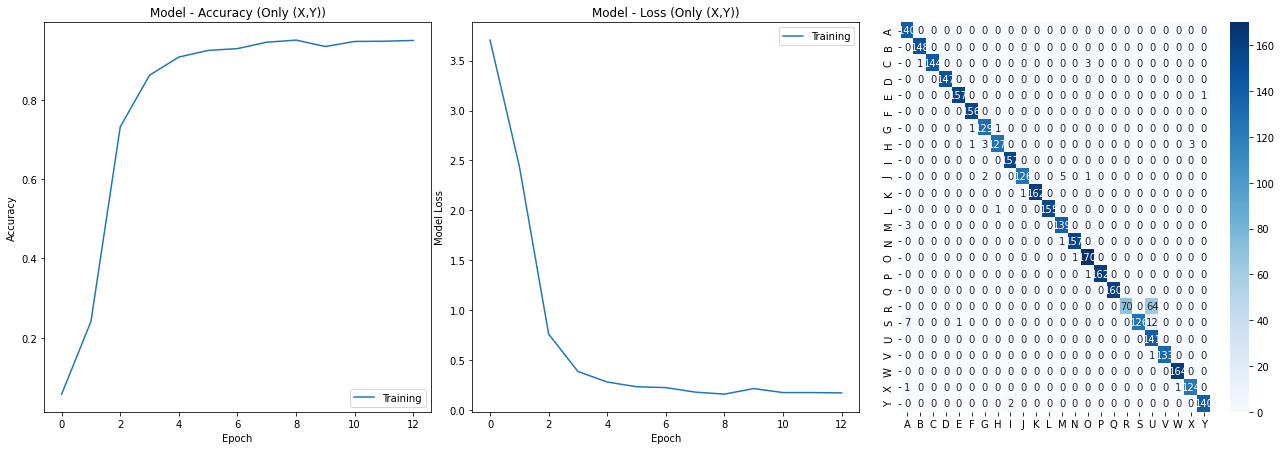


Accuracy: 96.65% 

              precision    recall  f1-score   support

           A       0.93      1.00      0.96       140
           B       0.99      1.00      1.00       148
           C       1.00      0.97      0.99       148
           D       1.00      1.00      1.00       147
           E       0.99      0.99      0.99       158
           F       0.99      1.00      0.99       156
           G       0.96      0.98      0.97       131
           H       0.98      0.95      0.97       134
           I       0.99      1.00      0.99       157
           J       0.99      0.94      0.97       134
           K       1.00      0.99      1.00       163
           L       1.00      0.99      1.00       156
           M       0.96      0.98      0.97       142
           N       0.99      0.99      0.99       158
           O       0.97      0.99      0.98       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [11]:
evaluate_model(history, X_test, y_test, model, "Only (X,Y)", actions)

### **b. Two Angles**

In [17]:
missing = []
data = []
labels = []
mpHands = mp.solutions.hands

with open('data/dimensions.pkl', 'rb') as f:
    x, y, c = pickle.load(f)

for action in actions:
    # Loop through sequences aka videos
    for sequence in range(0, 0 + no_sequences): 
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            pkl_path = os.path.join(LANDMARK_PATH, action, str(sequence), str(frame_num))
            try:
                with open(pkl_path, 'rb') as f:
                    result = pickle.load(f)

                # print(pkl_path)
                landmarks = []
                for handslms in result:
                    angle_1 = getAngle((handslms.landmark[mpHands.HandLandmark.THUMB_TIP].x, handslms.landmark[mpHands.HandLandmark.THUMB_TIP].y),
                                            (handslms.landmark[mpHands.HandLandmark.WRIST].x, handslms.landmark[mpHands.HandLandmark.WRIST].y),
                                            (handslms.landmark[mpHands.HandLandmark.PINKY_TIP].x, handslms.landmark[mpHands.HandLandmark.PINKY_TIP].y))

                    angle_2 = getAngle((handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_TIP].y),
                                        (handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].x, handslms.landmark[mpHands.HandLandmark.INDEX_FINGER_MCP].y),
                                        (handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].x, handslms.landmark[mpHands.HandLandmark.MIDDLE_FINGER_TIP].y))
                    # print(angle_1, angle_2)
                    for lm in handslms.landmark:
                        lmx = int(lm.x * x)
                        lmy = int(lm.y * y)
                        
                        landmarks.append([lmx, lmy])
                    landmarks.append([angle_1, angle_2])
                    # print(np.array(landmarks).shape)

                data.append(landmarks)
                labels.append(label_map[action])
                
            except:
                missing.append(pkl_path)

            
data = np.array(data)
labels = np.array(labels)

In [19]:
X_train, X_test, y_train, y_test = preprocess(data, labels)

Data Shape:  (17764, 22, 2) ||  Label Shape:  (17764,)

Original Label Distribution:
 {0: 747, 1: 748, 2: 746, 3: 748, 4: 749, 5: 749, 6: 605, 7: 718, 8: 748, 9: 746, 10: 749, 11: 749, 12: 750, 13: 749, 14: 749, 15: 748, 16: 731, 17: 748, 18: 750, 19: 745, 20: 746, 21: 748, 22: 749, 23: 749}

Training:
 (14211, 22, 2) (14211, 24) 


Test:
 (3553, 22, 2) (3553, 24) 



In [21]:
model, history = train_model( (X_train.shape[1],X_train.shape[2]), y_train.shape[1])

Epoch 1/50
445/445 [==============================] - 2s 4ms/step - loss: 2.2533 - accuracy: 0.5741
Epoch 2/50
445/445 [==============================] - 2s 4ms/step - loss: 0.3855 - accuracy: 0.8754
Epoch 3/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2942 - accuracy: 0.9088
Epoch 4/50
445/445 [==============================] - 2s 4ms/step - loss: 0.2468 - accuracy: 0.9236
Epoch 5/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1776 - accuracy: 0.9468
Epoch 6/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2092 - accuracy: 0.9364
Epoch 7/50
445/445 [==============================] - 1s 3ms/step - loss: 0.2040 - accuracy: 0.9373
Epoch 8/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1542 - accuracy: 0.9545
Epoch 9/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1395 - accuracy: 0.9597
Epoch 10/50
445/445 [==============================] - 1s 3ms/step - loss: 0.1727 - accuracy: 0.9506

In [22]:
model.save('./model_saves/two_angles')

INFO:tensorflow:Assets written to: ./model_saves/two_angles\assets


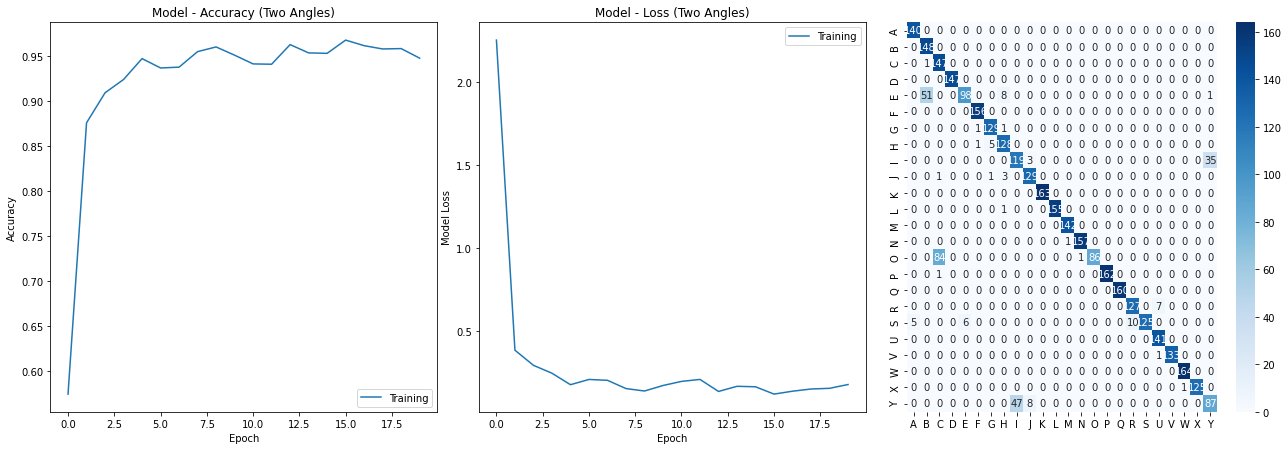


Accuracy: 91.98% 

              precision    recall  f1-score   support

           A       0.97      1.00      0.98       140
           B       0.74      1.00      0.85       148
           C       0.63      0.99      0.77       148
           D       1.00      1.00      1.00       147
           E       0.94      0.62      0.75       158
           F       0.99      1.00      0.99       156
           G       0.96      0.98      0.97       131
           H       0.91      0.96      0.93       134
           I       0.72      0.76      0.74       157
           J       0.92      0.96      0.94       134
           K       1.00      1.00      1.00       163
           L       1.00      0.99      1.00       156
           M       0.99      1.00      1.00       142
           N       0.99      0.99      0.99       158
           O       1.00      0.50      0.67       171
           P       1.00      0.99      1.00       163
           Q       1.00      1.00      1.00       160
       

In [25]:
evaluate_model(history, X_test, y_test, model, "Two Angles", actions)